# Load Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Load Data & Data Preparation

In [4]:
df = pd.read_csv("./data/04-Telco Customer Churn.csv")

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

# Train the Model

In [5]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [6]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [7]:
C = 1.0
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1.0 0.840 +- 0.008


In [8]:
scores

[0.8420649810426168,
 0.8437934545093365,
 0.832398153722657,
 0.8301724275756219,
 0.8510322864045685]

In [9]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

y_test = df_test.churn.values

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

# Saving and Loading the Model

## Save the Model

In [10]:
import pickle

In [12]:
# file name
output_file = f'model_C={C}.bin'
output_file

'model_C=1.0.bin'

We need both dv and model to save.

In [13]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

## Load the Model

In [1]:
import pickle

In [2]:
model_file = 'model_C=1.0.bin'

In [3]:
with open(model_file, 'rb') as f_in:
    (dv, model) = pickle.load(f_in)

In [4]:
 dv, model

(DictVectorizer(sparse=False), LogisticRegression(max_iter=1000))

In [5]:
customer = {
    "gender": "female",
    "seniorcitizen": 0,
    "partner": "yes",
    "dependents": "no",
    "phoneservice": "no",
    "multiplelines": "no_phone_service",
    "internetservice": "dsl",
    "onlinesecurity": "no",
    "deviceprotection": "no",
    "techsupport": "no",
    "streamingtv": "no",
    "streamingmovies": "no",
    "contract": "month-to-month",
    "paperlessbilling": "yes",
    "paymentmethod": "electronic_check",
    "tenure": 1,
    "monthlycharges": 29.85,
    "totalcharges": 29.85
}

In [6]:
# turn this customer into a feature matrix
X = dv.transform([customer])

In [7]:
X

array([[ 1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  1.  ,  0.  ,  0.  , 29.85,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,
         0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  , 29.85]])

In [9]:
# get churn probability
model.predict_proba(X)[0, 1]

0.6638191204267414

This is how a model can be saved and loaded later for prediction. However, it is not convinient to do in a jupyter notebook every time, so imagine that you want to train a model, you don't want to open the jupyter notebook and execute all the cells. So We want to have a single python file (a script that just does that).

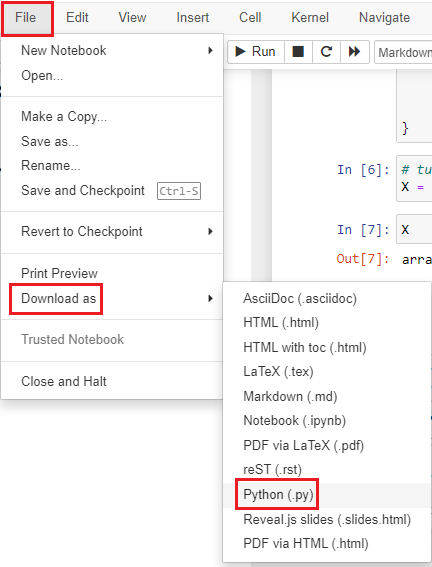

Take the code where you need it and clean it.
- Put all the import at the top
- Put parameters after imports
- Put the model loading in a new notebook (predict.py)
- Add a few logging (prints) in the code
- Run the code and then take a look at the size of the file: ls -lh 'filename.bin'
- Now, you can use the model (predict.py)